In [5]:
import PIL.Image
from urllib.request import urlopen
from dotenv import load_dotenv
from openai import OpenAI

# Load .env
load_dotenv(override=True)

# Configure API
client = OpenAI()
chat_model = "gpt-3.5-turbo-0125"
image_model = "dall-e-3"


In [6]:
# Write an intruction
instructions = """
Du är en hjälpsam assistent som kan svara på frågor och generera bilder.
"""

tools = [
    {
        "type": "function",
        "function": {
            "name": "create_answer",
            "description": "Create an answer based on the question",
        },
    },
    {
        "type": "function",
        "function": {
            "name": "create_image",
            "description": "Create an image based on the question",
        },
    },
]

def create_answer(messages: list):
    response = client.chat.completions.create(messages=messages, model=chat_model)
    answer = {"role": "assistant", "content": response.choices[0].message.content}
    return answer

def create_image(messages: list):
    prompt = messages[-1]["content"]
    response = client.images.generate(prompt=prompt, model=image_model)
    revised_prompt = response.data[0].revised_prompt
    url = response.data[0].url
    img = PIL.Image.open(urlopen(url)).convert("RGBA")
    return {"role": "assistant", "content": revised_prompt, "img": img}

def chat(question: str):
    print("user:", question)

    # Get tool_calls from question
    messages = [{"role": "system", "content": instructions}] + [{"role": "user", "content": question}]
    response = client.chat.completions.create(messages=messages, tools=tools, model=chat_model)
    tool_calls = response.choices[0].message.tool_calls

    # Create output from tool_calls
    output = []
    if tool_calls is None:
        print("tool_call: None")
        result = create_answer(messages)
        output.append(result)
    else:
        for tool_call in tool_calls:
            if tool_call.function.name == "create_answer":
                print("tool_call: create_answer()")
                result = create_answer(messages)
            elif tool_call.function.name == "create_image":
                print("tool_call: create_image()")
                result = create_image(messages)
            output.append(result)

    # Print output
    for msg in output:
        print(f"{msg['role']}:\n'{msg['content']}'")

        # Display image
        if "img" in msg:
            display(msg["img"])


In [7]:
question = """Skriv en haiku om en grön fluffig hund"""
chat(question)


user: Skriv en haiku om en grön fluffig hund
tool_call: create_answer()
assistant:
'Grön päls som skiftar,
Fluffig vän i hundens skepnad,
Naturens under.'


user: Skapa en bild av en grön fluffig hund
tool_call: create_image()
assistant:
'Generate an image of a fluffy dog with green fur, bright eyes and playful demeanor, gleefully jumping around in a garden filled with blooming flowers. The sun is peeking through the clouds, casting long, dramatic shadows on the ground, highlighting the vivid color of the dog's fur. The dog is mid-jump, with its tongue hanging out, looking absolutely adorable. The image should evoke a feeling of joy, similar to an idyllic summer afternoon.'


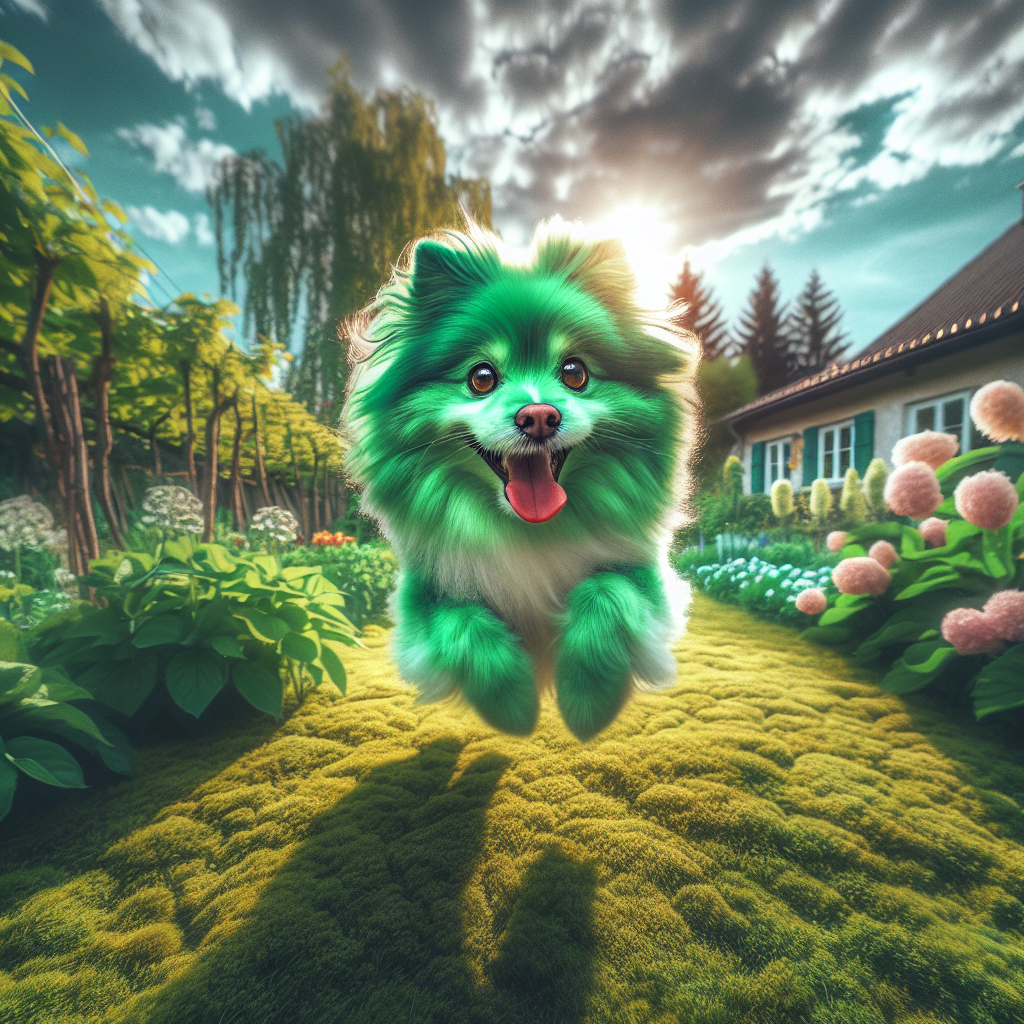

In [8]:
question = """Skapa en bild av en grön fluffig hund"""
chat(question)
